In [2]:
!pip install transformers bertopic pandas matplotlib seaborn torch
!pip install emoji -q

import emoji
import pandas as pd
import numpy as np
from google.colab import drive
from transformers import pipeline
from bertopic import BERTopic
import torch
from tqdm.auto import tqdm

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/SOSC314/CNN Dataset/CNN_Comments_Cleaned.csv'
df = pd.read_csv(file_path)

In [5]:
# Data cleaning: Remove null values, conversion time
df = df.dropna(subset=['comment_text'])
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# trial 10000
#df = df.sample(10000, random_state=42).reset_index(drop=True)

print(f"Total comments to analyze: {len(df)}")

Total comments to analyze: 139999


In [6]:
# ==========================================
# 2. Data Loading and Preprocessing (Revised Version)
# ==========================================

# 1. 1. Replace _x000D_ with a blank or space
df['comment_text'] = df['comment_text'].str.replace(r'_x000D_', ' ', regex=True)

# 2. Incidentally, handle other common escape characters (optional)
df['comment_text'] = df['comment_text'].str.replace(r'\n', ' ', regex=True) # Handle line breaks
df['comment_text'] = df['comment_text'].str.replace(r'\s+', ' ', regex=True) # Merge multiple Spaces into one

df = df.dropna(subset=['comment_text'])
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

print(f"Cleaned! Total comments: {len(df)}")

Cleaned! Total comments: 139999


In [7]:
import re

emoji_pattern = re.compile(r'[^\x00-\x7F]+')

# 3. Statistics and screening
df['has_emoji'] = df['comment_text'].apply(lambda x: bool(emoji_pattern.search(str(x))))
emoji_df = df[df['has_emoji'] == True]

print(f"--- Re-test results ---")
print(f"Re-test results {len(emoji_df)}")

# 4. Let's take a look at 10 of them
print("\nThe first 10 detected comment examples")
for idx, text in enumerate(emoji_df['comment_text'].head(10)):
    print(f"{idx+1}. {text}")

--- Re-test results ---
Re-test results 33948

The first 10 detected comment examples
1. Hear the one where the caught bank robber yells “I’m disabled!”? 😂
2. Trying to find any way to make excuses. She is lying 🤥 She knew what she was doing, but now she wants everyone to feel sorry for her. Her problem is her self. Hope she gets jail time.
3. Remember a$$holes aren’t going to stop sh!ting on people when that what the a$$es are made for?
4. These wannabe cops have no training, they've been given guns and the illusion that they're untouchable, and they seem to have IQs lower than their shoe sizes. They've also been given an objective to arrest x number of people per day. What could possibly go wrong? Maybe MAGA will be happy to pay for the thousands and thousands of lawsuits that will determine guilt, compensation and jail time in the future. Reasonable people aren't, because they knew in advance what was going to happen. Kamala, Hillary and many others said it many times in advance. Bu

In [8]:

# ==========================================
# 3. Multi-emotion Recognition (Emotion Analysis)
# ==========================================
print("Initializing Emotion Classifier...")
# Accelerate using GPU (device=0)
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=False,
    device=0
)

def batch_emotion_analysis(texts, batch_size=64):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing Emotions"):
        batch = texts[i:i+batch_size]

        # Core Fix: Add the truncation parameter when calling
        try:
            batch_results = emotion_model(
                [str(t) for t in batch],
                truncation=True,
                max_length=512
            )
            results.extend([res['label'] for res in batch_results])
        except Exception as e:
            print(f"Error at batch {i}: {e}")
            #If an Error still occurs in a certain batch, you can fill it with 'Neutral' or' Error' to ensure consistent lengths
            results.extend(['Neutral'] * len(batch))

    return results
#sentiment analysis
df['emotion'] = batch_emotion_analysis(df['comment_text'].tolist())

Initializing Emotion Classifier...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: j-hartmann/emotion-english-distilroberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Analyzing Emotions:   0%|          | 0/2188 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [9]:
def batch_emotion_analysis_with_scores(texts, batch_size=64):
    labels = []
    scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing Emotions"):
        batch = [str(t)[:512] for t in texts[i:i+batch_size]]
        try:
            # batch_results here will contain [{' label ':' anger (', 'score: 0.99},...
            batch_results = emotion_model(batch, truncation=True, max_length=512)
            labels.extend([res['label'] for res in batch_results])
            scores.extend([res['score'] for res in batch_results])
        except Exception as e:
            print(f"Error at batch {i}: {e}")
            labels.extend(['neutral'] * len(batch))
            scores.extend([0.0] * len(batch))
    return labels, scores

# Execute and save two columns
df['emotion_label'], df['emotion_score'] = batch_emotion_analysis_with_scores(df['comment_text'].tolist())

Analyzing Emotions:   0%|          | 0/2188 [00:00<?, ?it/s]

In [10]:
# Get all the non-repetitive emotion labels
unique_emotions = df['emotion_label'].unique()

print("=== Top Confidence comments for each emotion ===\n")

for emotion in unique_emotions:
    print(f"【Emotion category: {emotion.upper()}】")

    #Filter this emotion and sort it from high to low by score
    #Here we get top 5 comments with highest scores
    top_comments = df[df['emotion_label'] == emotion].sort_values(by='emotion_score', ascending=False).head(5)

    for i, (idx, row) in enumerate(top_comments.iterrows()):
        print(f"{i+1}. [Confidence score: {row['emotion_score']:.4f}]")
        print(f"   Full Comment: {row['comment_text']}")
        print()
    print("-" * 80)

=== Top Confidence comments for each emotion ===

【Emotion category: NEUTRAL】
1. [Confidence score: 0.9745]
   Full Comment: It all starts with one, just ask Maduro. This won't be trump's last.

2. [Confidence score: 0.9745]
   Full Comment: It’s pretty simple to me just stop voting for a presidents till we can find someone that is capable of doing the job

3. [Confidence score: 0.9743]
   Full Comment: ICE will continue. Learn it Love it Live it

4. [Confidence score: 0.9743]
   Full Comment: If you have time to draw a weapon, you have plenty of time to step aside. Not to mention there's a license plate on the car, which means you can always visit people at home later. (Before someone replies that plates can be fake, at least 90% of the plates must be real right.)

5. [Confidence score: 0.9742]
   Full Comment: There is a pathway to citizenship already in place. Most countries have laws in place for citizenship.

------------------------------------------------------------------------

In [11]:
# ==========================================
# 4. Dynamic Topic Modeling (Make corrections at the step of Dynamic Topic modeling)(vectorized)
# ==========================================
from sklearn.feature_extraction.text import CountVectorizer

print("Running BERTopic with optimized Vectorizer...")

# Define the Vectorizer before the model initialization
#This will filter out "the", "is", "of", etc. in the hashtags and allow two-word phrases like "ice agents" to appear
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=10
)

# Pass in vectorizer_model when initializing the model
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language="english",
    calculate_probabilities=False,
    verbose=True
)

# Perform fitting
topics, probs = topic_model.fit_transform(df['comment_text'].tolist())

df['topic'] = topics

# Then proceed with the analysis of the time dimension.
timestamps = df['timestamp'].tolist()
topics_over_time = topic_model.topics_over_time(df['comment_text'].tolist(), timestamps)

2026-02-03 09:30:17,953 - BERTopic - Embedding - Transforming documents to embeddings.


Running BERTopic with optimized Vectorizer...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4375 [00:00<?, ?it/s]

2026-02-03 09:32:00,976 - BERTopic - Embedding - Completed ✓
2026-02-03 09:32:00,977 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-03 09:34:59,491 - BERTopic - Dimensionality - Completed ✓
2026-02-03 09:34:59,496 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-03 09:35:17,692 - BERTopic - Cluster - Completed ✓
2026-02-03 09:35:17,730 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-03 09:35:23,211 - BERTopic - Representation - Completed ✓
73it [00:20,  3.56it/s]


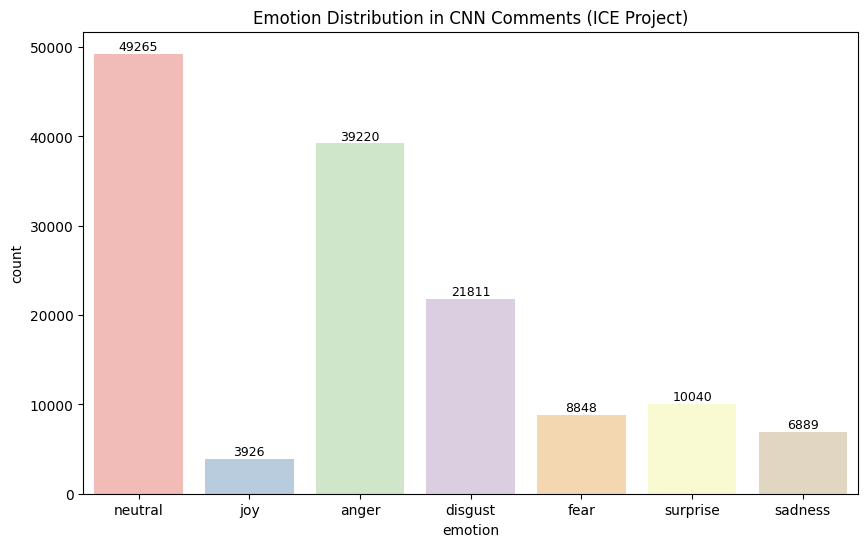

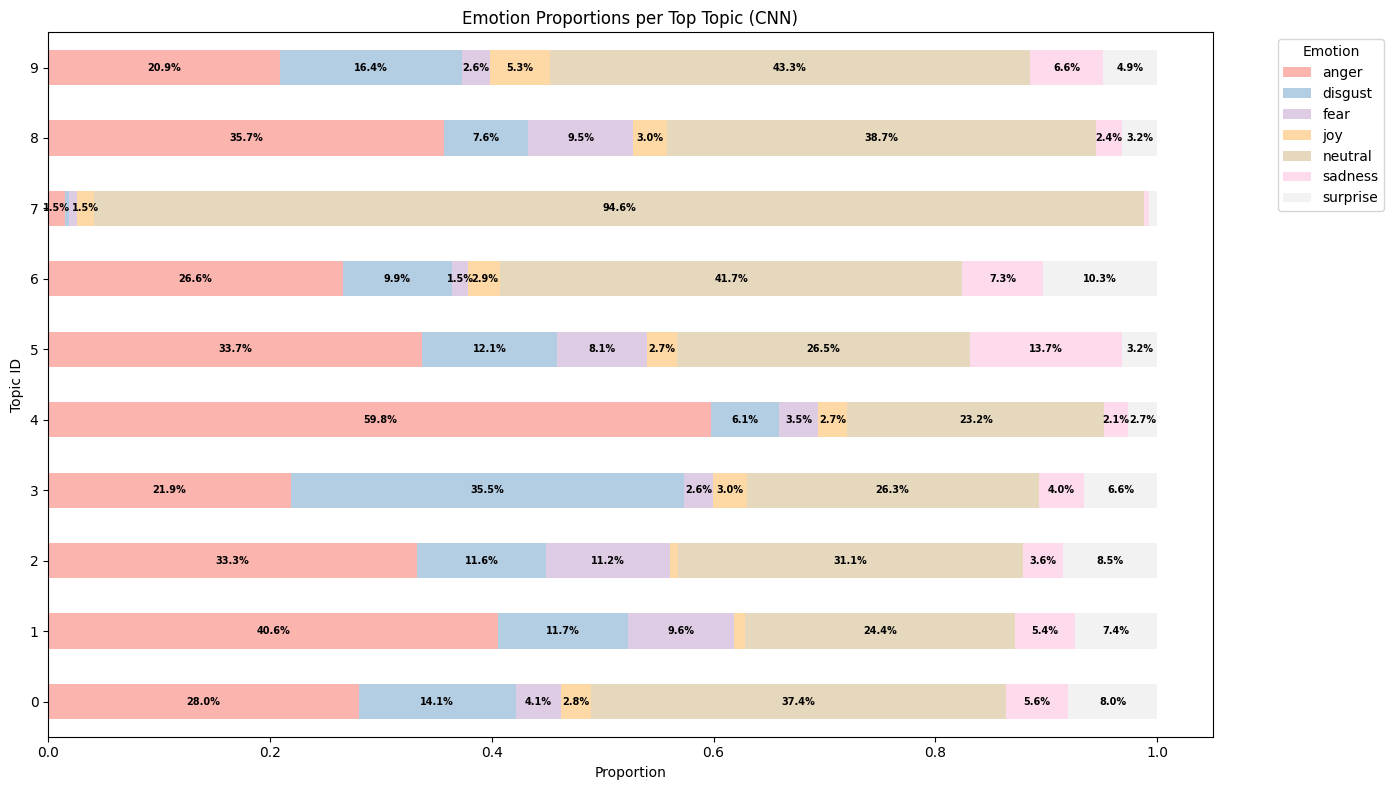

Analysis complete. Results saved to /content/drive/My Drive/SOSC314/CNN Dataset/CNN_DTM_Analysis_Results.csv


In [14]:
# ==========================================
# 5. Visualization and result export
# ==========================================

# A. A diagram of the evolution of the theme over time
fig_topic_time = topic_model.visualize_topics_over_time(topics_over_time)
fig_topic_time.show()

# B. Emotion distribution statistics
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='emotion', palette='Pastel1') # Changed palette to 'Pastel1'
plt.title('Emotion Distribution in CNN Comments (ICE Project)')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

# C. Theme - Emotion Cross-Analysis (Key: See which topics make people the angrier/most frightened)
# Filter out the top 10 popular topics (excluding topic -1 which is noise)
top_10_topics = df['topic'].value_counts().iloc[1:11].index.tolist()
df_top_filtered = df[df['topic'].isin(top_10_topics)]

# Calculate emotion proportions for each of the top topics
emotion_proportions = df_top_filtered.groupby('topic')['emotion'].value_counts(normalize=True).unstack(fill_value=0)

# Ensure topics are ordered by frequency for consistent visualization
emotion_proportions = emotion_proportions.loc[top_10_topics]

plt.figure(figsize=(14, 8))
ax_prop = emotion_proportions.plot(kind='barh', stacked=True, colormap='Pastel1', ax=plt.gca()) # Changed colormap to 'Pastel1'
plt.title('Emotion Proportions per Top Topic (CNN)')
plt.xlabel('Proportion')
plt.ylabel('Topic ID')

# Add percentage labels to each segment
for container in ax_prop.containers:
    for patch in container.patches:
        width = patch.get_width()
        if width > 0.01: # Only label if there's a significant segment
            x = patch.get_x() + width / 2
            y = patch.get_y() + patch.get_height() / 2
            ax_prop.text(x, y, f'{width:.1%}', ha='center', va='center',
                         fontsize=7, color='black', weight='bold')

plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# D. Export results
output_path = '/content/drive/My Drive/SOSC314/CNN Dataset/CNN_DTM_Analysis_Results.csv'
df.to_csv(output_path, index=False)
print(f"Analysis complete. Results saved to {output_path}")